# Integilência Computacional - Trabalho 01 - Redes Neurais Artificiais

Alunos:

- Heitor Freitas Ferreira
- Yuri Henrique B. Maciel

## Artigo base

O [artigo](./olaniyi2015.pdf) aborda o problema da alta incidência de doenças cardíacas, que resultam em um número significativo de mortes anualmente, especialmente nos Estados Unidos, onde cerca de 800.000 pessoas morrem de doenças cardíacas a cada ano. Além disso, muitas pessoas vivem com doenças cardíacas sem saber, o que as torna ainda mais perigosas, sendo chamadas de "assassinos silenciosos". Fatores de risco como tabagismo, dieta inadequada e pressão arterial alta aumentam as chances de desenvolver essas doenças. Devido ao risco elevado de diagnósticos errados, o artigo enfatiza a necessidade de sistemas inteligentes para diagnosticar doenças cardíacas com alta precisão, utilizando redes neurais artificiais como uma solução promissora para prevenir diagnósticos equivocados.

## O dataset

O dataset utilizado no artigo é o [Cleveland Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease), que  14 atributos, sendo 13 atributos preditivos e um atributo de classe. Os atributos preditivos são:

| Variable Name | Role    | Type         | Demographic | Description                                       | Units  | Missing Values |
|---------------|---------|--------------|-------------|---------------------------------------------------|--------|----------------|
| age           | Feature | Integer      | Age         |                                                   | years  | no             |
| sex           | Feature | Categorical  | Sex         |                                                   |        | no             |
| cp            | Feature | Categorical  |             |                                                   |        | no             |
| trestbps      | Feature | Integer      |             | resting blood pressure (on admission to the hospital) | mm Hg  | no             |
| chol          | Feature | Integer      |             | serum cholestoral                                 | mg/dl  | no             |
| fbs           | Feature | Categorical  |             | fasting blood sugar > 120 mg/dl                   |        | no             |
| restecg       | Feature | Categorical  |             |                                                   |        | no             |
| thalach       | Feature | Integer      |             | maximum heart rate achieved                       |        | no             |
| exang         | Feature | Categorical  |             | exercise induced angina                           |        | no             |
| oldpeak       | Feature | Integer      |             | ST depression induced by exercise relative to rest |        | no             |

### Referência

E. O. Olaniyi, O. K. Oyedotun, A. Helwan and K. Adnan, "Neural network diagnosis of heart disease," 2015 International Conference on Advances in Biomedical Engineering (ICABME), Beirut, Lebanon, 2015, pp. 21-24, doi: 10.1109/ICABME.2015.7323241.


In [1]:
from typing import Dict, Callable, Union, Iterable, Literal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import seaborn as sns

# Constants
num_experiments = 300 # Number of experiments to run
seed = 2954135436  # Seed for reproducibility

# Juntando os dados em um único DataFrame

In [2]:
def get_data_gathered(cities: list[str] = ['cleveland'], save: bool = False) -> pd.DataFrame:
    columns = [
        'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
    ]

    def load_data(file_path: str) -> pd.DataFrame:
        df = pd.read_csv(file_path, header=None, names=columns, na_values='?')
        return df

    files: list[str] = [f'./data/processed.{city}.data' for city in cities]

    result_df = pd.concat([load_data(file)
                          for file in files], ignore_index=True)
    if save:

        output_path = f'./data/heart_disease_{"_".join(cities)}.csv'
        result_df.to_csv(output_path, index=False)
        print(f"Arquivo CSV criado com sucesso em: {output_path}")

    return result_df

# Pré processamento dos dados

Foram implementadas 2 alternativas para teste, uma em que os valores nulos são preenchidos, e outra em que os valores nulos são removidos.

In [3]:
def deal_with_nil(original_df: pd.DataFrame, drop_nulls: bool = True) -> pd.DataFrame:
    if drop_nulls:
        return original_df.dropna()

    df = original_df.copy()
    # Substitua lacunas para frente do valor válido anterior em: 'trestbps'
    df = df.fillna({'trestbps': df['trestbps'].ffill()})
    # Substitua os valores ausentes pela média de cada coluna em: 'chol'
    df = df.fillna({'chol': df['chol'].mean()})
    # Substitua as lacunas do próximo valor válido em: 'fbs'
    df = df.fillna({'fbs': df['fbs'].bfill()})
    # Substitua os valores ausentes pela média de cada coluna em: 'thalach'
    df = df.fillna({'thalach': df['thalach'].mean()})
    # Substitua os valores ausentes pelo modo de cada coluna em: 'restecg'
    df = df.fillna({'restecg': df['restecg'].mode()[0]})
    # Substitua os valores ausentes pelo modo de cada coluna em: 'exang'
    df = df.fillna({'exang': df['exang'].mode()[0]})
    # Remover coluna: 'ca' (muitos nulls)
    df = df.drop(columns=['ca'])
    # Substitua lacunas para frente do valor válido anterior em: 'slope'
    df = df.fillna({'slope': df['slope'].ffill()})
    # Substitua os valores ausentes pelo modo de cada coluna em: 'thal'
    df = df.fillna({'thal': df['thal'].mode()[0]})
    # Substitua lacunas para frente do valor válido anterior em: 'oldpeak'
    df = df.fillna({'oldpeak': df['oldpeak'].ffill()})
    return df

Para a normalização foi usado o MinMaxScaler, que transforma os dados para que fiquem entre 0 e 1. Transformando a coluna objetivo em 0 e 1. Onde 0 é saudável e 1 é doente, no banco de dados original os valores são [0..4], onde qualquer número >0 é não saudável.

![preprocessamento](./assets/pre-processing.png)

In [4]:
def normalize(original_df: pd.DataFrame) -> pd.DataFrame:
    df_clean = original_df.copy()
    print("Quantidade de classes nos dados limpos:")
    print(df_clean['num'].value_counts())

    df_clean['num'] = df_clean['num'].apply(
        lambda x: 0 if x == 0 else 1)

    scaler = MinMaxScaler()
    df_clean_normalized = df_clean.copy()
    df_clean_normalized = pd.DataFrame(scaler.fit_transform(
        df_clean_normalized), columns=df_clean_normalized.columns)

    df_clean_normalized.describe()

    df_clean_normalized['num'] = df_clean_normalized['num'].astype(bool)

    print("Quantidade de classes nos dados normalizados:")
    print(df_clean_normalized['num'].value_counts())

    return df_clean_normalized

In [5]:
df: pd.DataFrame = normalize(deal_with_nil(get_data_gathered()))

df.head()

Quantidade de classes nos dados limpos:
num
0    160
1     54
2     35
3     35
4     13
Name: count, dtype: int64
Quantidade de classes nos dados normalizados:
num
False    160
True     137
Name: count, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,0.708333,1.0,0.000000,0.481132,0.244292,1.0,1.0,0.603053,0.0,0.370968,1.0,0.000000,0.75,False
1,0.791667,1.0,1.000000,0.622642,0.365297,0.0,1.0,0.282443,1.0,0.241935,0.5,1.000000,0.00,True
2,0.791667,1.0,1.000000,0.245283,0.235160,0.0,1.0,0.442748,1.0,0.419355,0.5,0.666667,1.00,True
3,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.0,0.885496,0.0,0.564516,1.0,0.000000,0.00,False
4,0.250000,0.0,0.333333,0.339623,0.178082,0.0,1.0,0.770992,0.0,0.225806,0.0,0.000000,0.00,False


# Replicando a arquitetura do artigo

Parametros do melhor modelo encontrado no artigo:

![best parameters](./assets/best_params.png)


In [6]:
X = df.drop('num', axis=1)
y = df['num']

## Dividindo em treino e teste 60:40
Foi feito assim como no artigo.

*"The dataset was divided using ratio 60:40 i.e. 60% of the 2015 International Conference on Advances in Biomedical Engineering (ICABME) 22 dataset for training and 40% of the dataset for testing of the network. This is the standard ratio for dividing dataset in machine learning datase"*

In [7]:
# Divide o dataset em 60% treino e 40% teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

# Exibe os tamanhos dos conjuntos de treino e teste
print(f'Tamanho do conjunto de treino: {X_train.shape[0]}')
print(f'Tamanho do conjunto de teste: {X_test.shape[0]}')

Tamanho do conjunto de treino: 178
Tamanho do conjunto de teste: 119


## Treinamento do modelo

Para implementação da rede neural retropropagada foi utilizado o scikit-learn, que possui um [pacote de rede neural retropropagada](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#mlp-tips).

Os resultados publicados no artigo é que o modelo implementado (MLP) obteve uma acurácia de 85%, que é maior que os resultados obtidos com outros modelos de classificação, porém o não foi fornecido um conjunto de seeds para que o experimento realizado no artigo fosse reproduzido. Desse modo, geramos seeds aleatoriamente até que encontrassemos uma que gerasse uma acurácia próxima a 85%. Ao executar o código com outras sementes o resultado pode variar como demonstrado mais abaixo.

![resultados](./assets/comparison.png)

Acurácia: 0.865546218487395


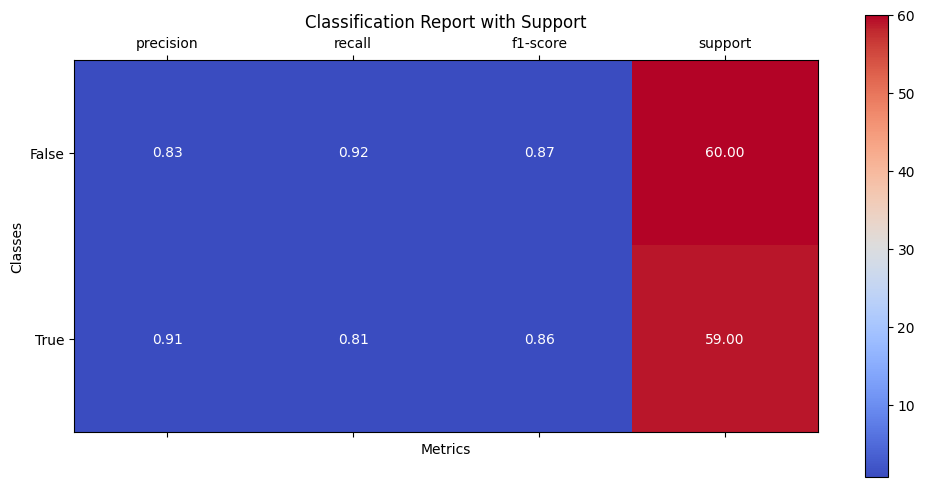

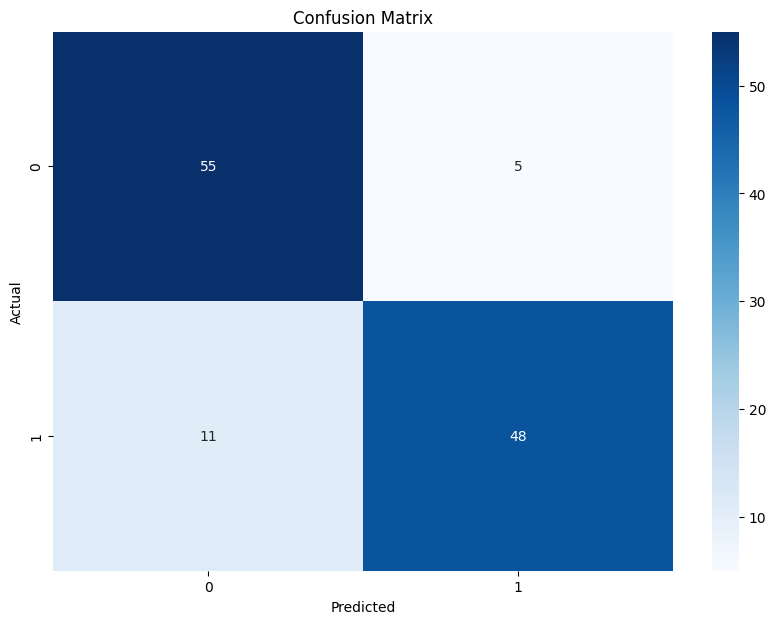

In [8]:
def plot_classification_report_with_support(report):
    # Exclude 'accuracy', 'macro avg', 'weighted avg'
    labels = list(report.keys())[:-3]
    metrics = ['precision', 'recall', 'f1-score', 'support']
    data = np.array([[report[label][metric]
                    for metric in metrics] for label in labels])
    _, ax = plt.subplots(figsize=(12, 6))
    cax = ax.matshow(data, cmap='coolwarm')
    plt.xticks(range(len(metrics)), metrics)
    plt.yticks(range(len(labels)), labels)
    plt.colorbar(cax)
    for (i, j), val in np.ndenumerate(data):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.title('Classification Report with Support')
    plt.show()

def plot_confusion_matrix(cm: np.ndarray):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

np.random.seed(seed)

model_60_40 = MLPClassifier(hidden_layer_sizes=(
    6,), max_iter=2000, learning_rate_init=0.32, momentum=0.72, activation='logistic')

model_60_40.fit(X_train, y_train)

score = model_60_40.score(X_test, y_test)

print(f'Acurácia: {score}')

y_pred = model_60_40.predict(X_test)
plot_classification_report_with_support(
    classification_report(y_test, y_pred, output_dict=True)
)

plot_confusion_matrix(confusion_matrix(y_test, y_pred))


# Experimentos realizados

Para padronizar os experimentos foi criado um framework que recebe quais parâmetros devem ser testados e retorna a média e desvio padrão dos resultados obtidos.
Para cada variação de parâmetros, foram coletados dados de 300 execuções, onde a semente de geração de números aleatórios foi alterada a cada execução de acordo com o número da execução $[0..300)$

Para cada experimento foi coletada a média de acurácia dentre as 300 execuções, e foi plotado um gráfico onde no eixo x está o parâmetro variado e no eixo y linhas representando a acurácia média, minima, máxima, e desvio padrão.

In [9]:
ExperimentType = Callable[[Union[str, int]], np.float64]
ExperimentResults = Dict[Union[str, int], Dict[str, np.float64]]


def experiment_runner(param_range: Iterable, experiment: ExperimentType, set_seed: Literal['best', 'range', False] = 'range') -> ExperimentResults:
    """
        Run experiments with different parameters and return the best parameter, best score, and standard deviation.
        Args:
            param_range (Iterable): A range of parameters to be tested.
            experiment (ExperimentType): A function that takes a parameter and returns a score.
        Returns:
            (Tuple[Tuple[Union[str, int], np.float64], np.float64]): A tuple containing the best parameter, best score, and standard deviation.
    """
    over_all_results: ExperimentResults = {param: {} for param in param_range}
    for param in param_range:  # Para cada parametro que está sendo variado
        param_results = []
        # Executa o experimento num_experiments (1000) vezes
        for range_seed in range(num_experiments):
            match set_seed:
                case 'best':
                    np.random.seed(seed)  # Define a semente com melhor resultado no modelo do artigo
                case 'range':
                    np.random.seed(range_seed) # Define a semente aleatória
                case _:
                    ...

            # executa o experimento e recebe a acurácia
            score = experiment(param)
            param_results.append(score)

        over_all_results[param]['mean'] = np.mean(param_results)
        over_all_results[param]['std_dev'] = np.std(param_results)
        over_all_results[param]['max'] = np.max(param_results)
        over_all_results[param]['min'] = np.min(param_results)
    return over_all_results


def plot_experiment_results(results: ExperimentResults, x_label: str, y_label: str, title: str):
    """
        Plot the results of an experiment.
        Args:
            results (ExperimentResults): The results of the experiment.
            x_label (str): The label for the x-axis.
            y_label (str): The label for the y-axis.
            title (str): The title of the plot.
    """
    x = list(results.keys())
    y_mean = [results[param]['mean'] for param in x]
    y_std_dev = [results[param]['std_dev'] for param in x]
    y_max = [results[param]['max'] for param in x]
    y_min = [results[param]['min'] for param in x]

    plt.errorbar(x, y_mean, yerr=y_std_dev, fmt='o-',
                 capsize=5, label='Mean ± Std Dev')
    plt.plot(x, y_max, 'g--', label='Max')
    plt.plot(x, y_min, 'r--', label='Min')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

## Primeira modificação: K Fold

Nesta modificação iremos usar **kfold** com [2..20] splits ao invés de dividir em 60:40.

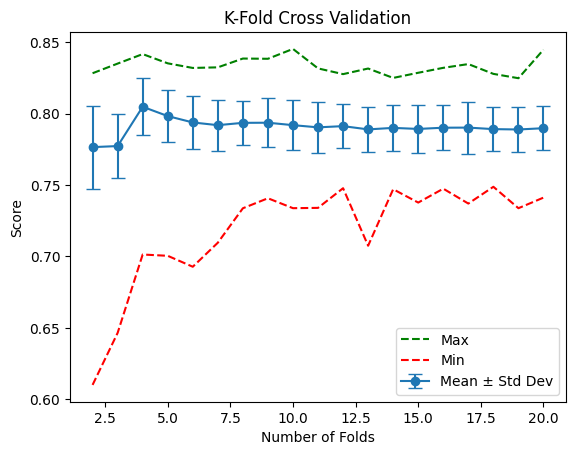

In [10]:
def k_fold_experiment(n_folds: Union[int, str]) -> np.float64:
    assert isinstance(n_folds, int)
    kf = KFold(n_splits=n_folds, shuffle=True)

    model_kfold = MLPClassifier(
        hidden_layer_sizes=(6,), 
        max_iter=2000, 
        learning_rate_init=0.32, 
        momentum=0.72, 
        activation='logistic'
    )

    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_kfold.fit(X_train, y_train)
        score = model_kfold.score(X_test, y_test)
        scores.append(score)

    return np.mean(scores)

results = experiment_runner(range(2, 21), k_fold_experiment)

plot_experiment_results(
    results,
    'Number of Folds',
    'Score',
    'K-Fold Cross Validation'
)

### Melhor número de K-Folds

Melhor número de folds: 4
Acurácia média: 0.8117117117117116


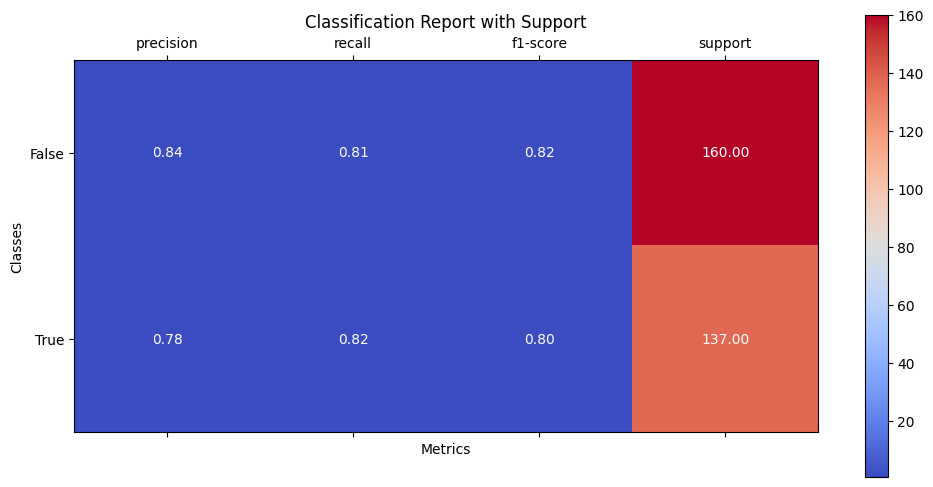

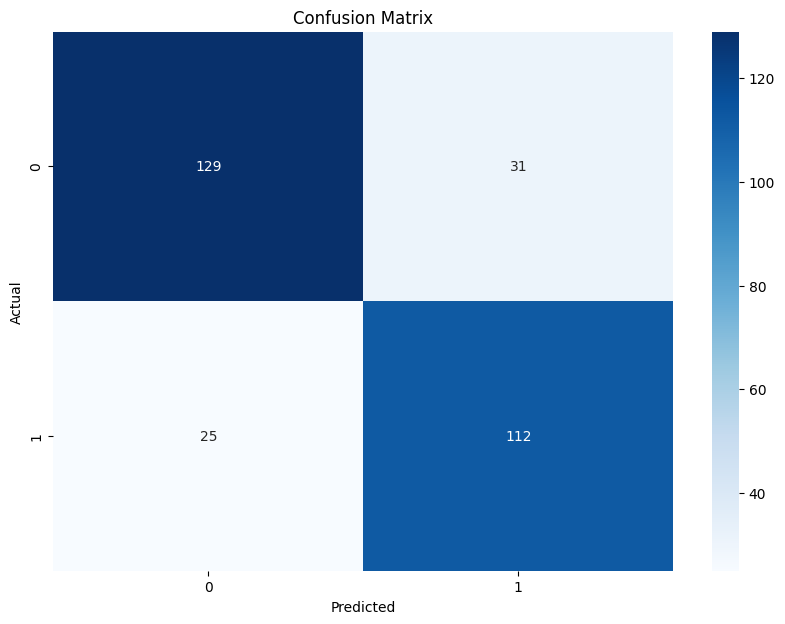

In [11]:
# Obtem melhor número de folds
best_n_folds = max(results, key=lambda x: results[x]['mean']) # type: ignore

print(f'Melhor número de folds: {best_n_folds}')

np.random.seed(seed)
kf = KFold(n_splits=best_n_folds, shuffle=True)
model_kfold = MLPClassifier(
    hidden_layer_sizes=(6,), 
    max_iter=2000, 
    learning_rate_init=0.32, 
    momentum=0.72, 
    activation='logistic'
)

all_y_true = []
all_y_pred = []

scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_kfold.fit(X_train, y_train)
    
    y_pred = model_kfold.predict(X_test)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    
    score = model_kfold.score(X_test, y_test)
    scores.append(score)

print(f'Acurácia média: {np.mean(scores)}')

# Obtem relatório de classificação
plot_classification_report_with_support(
    classification_report(all_y_true, all_y_pred, output_dict=True)
)

# Obtem matriz de confusão
cm = confusion_matrix(all_y_true, all_y_pred)
plot_confusion_matrix(cm)

## Segunda modificação: Épocas

Aqui variamos o número de épocas da arquitetura original.

O número de épocas foi variado de 400 a 3000 com passo de 200.

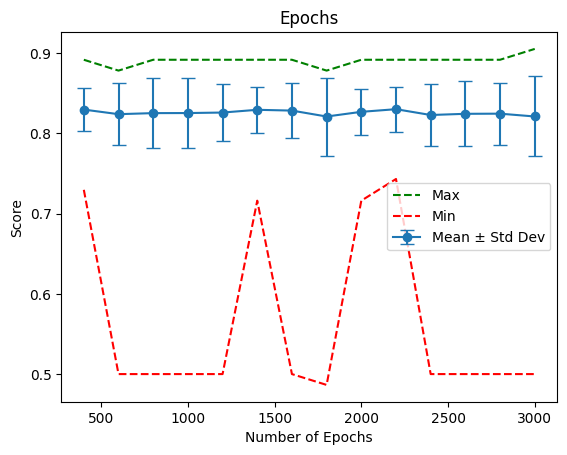

In [12]:
def epoch_experiment(epochs: Union[int, str]) -> np.float64:
    assert isinstance(epochs, int)
    model_60_40 = MLPClassifier(hidden_layer_sizes=(
        6,), max_iter=epochs, learning_rate_init=0.32, momentum=0.72, activation='logistic')

    model_60_40.fit(X_train, y_train)
    return np.float64(model_60_40.score(X_test, y_test))

results = experiment_runner(range(400, 3001, 200), epoch_experiment, set_seed=False)

plot_experiment_results(
    results,
    'Number of Epochs',
    'Score',
    'Epochs'
)

### Melhor número de Épocas

Melhor número de epochs: 2200
Acurácia: 0.8513513513513513


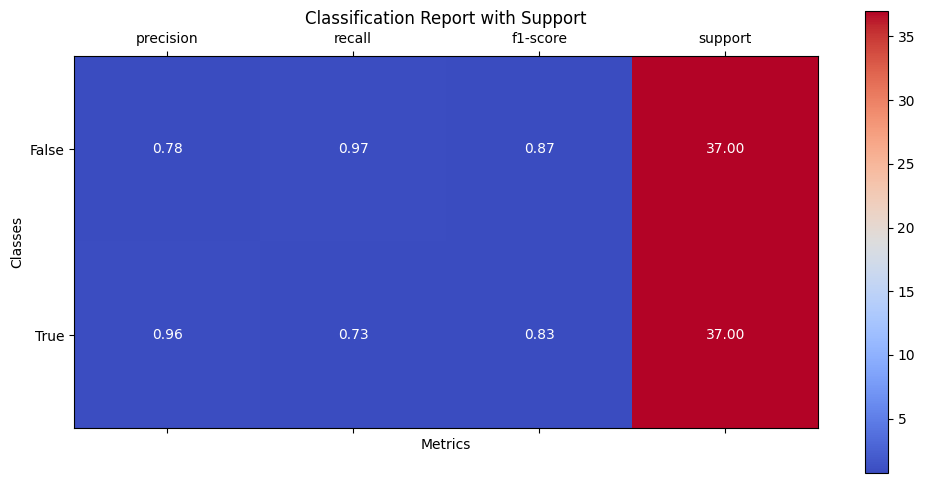

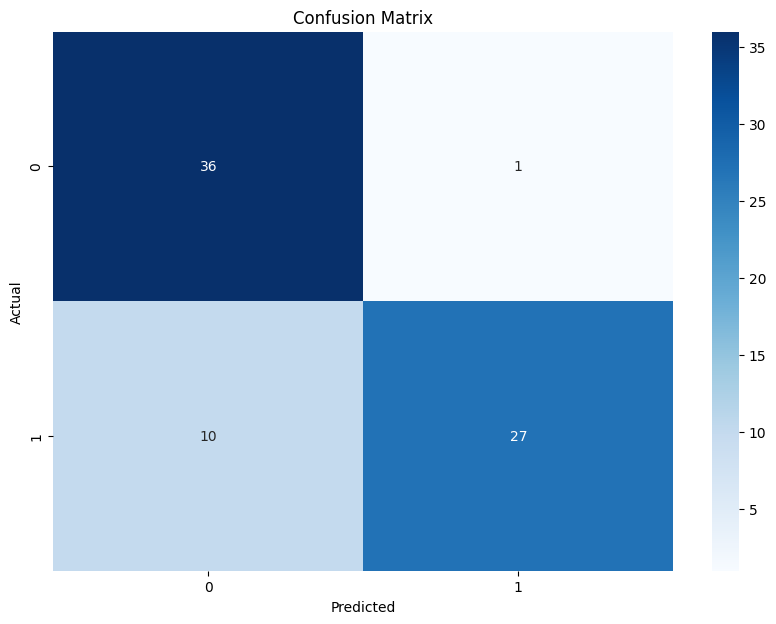

In [13]:
# Obtem melhor número de epochs
best_epochs = max(results, key=lambda x: results[x]['mean']) # type: ignore
print(f'Melhor número de epochs: {best_epochs}')

np.random.seed(seed)
model_best_epochs = MLPClassifier(
    hidden_layer_sizes=(6,), max_iter=best_epochs, learning_rate_init=0.32, momentum=0.72, activation='logistic'
)

model_best_epochs.fit(X_train, y_train)

y_pred = model_best_epochs.predict(X_test)

score = model_best_epochs.score(X_test, y_test)
print(f'Acurácia: {score}')

plot_classification_report_with_support(
    classification_report(y_test, y_pred, output_dict=True)
)

plot_confusion_matrix(confusion_matrix(y_test, y_pred))


### Usando seeds

Ao definir a seed como nos outros experimentos, notamos que o número de épocas não afeta o resultado do modelo, como é possível ver no gráfico abaixo.

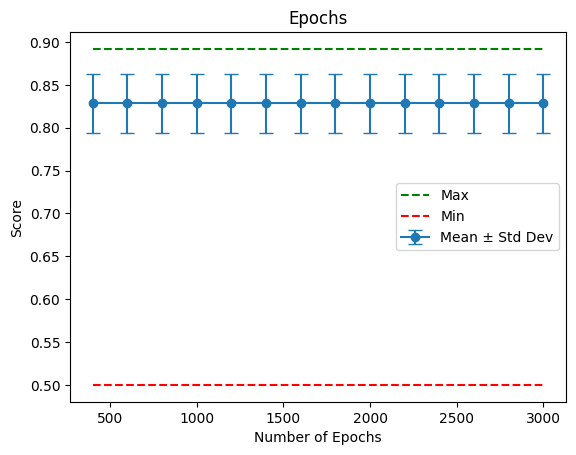

In [14]:
plot_experiment_results(
    experiment_runner(range(400, 3001, 200), epoch_experiment, set_seed='range'),
    'Number of Epochs',
    'Score',
    'Epochs'
)

## Terceira modificação: Função de Ativação

Aqui testamos a arquitetura original com todas as funções de ativação disponíveis no sklearn (relu, identity, tanh, logistic).

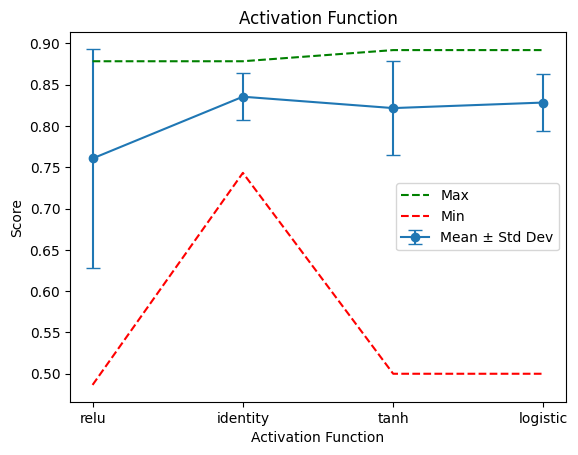

In [15]:
def activation_function_experiment(activation: Union[str, int]) -> np.float64:
    assert isinstance(activation, str)
    assert activation in ['relu', 'identity', 'tanh', 'logistic']
    model_60_40 = MLPClassifier(hidden_layer_sizes=(
        6,), max_iter=2000, learning_rate_init=0.32, momentum=0.72, activation=activation)  # type: ignore

    model_60_40.fit(X_train, y_train)
    return np.float64(model_60_40.score(X_test, y_test))

results = experiment_runner(['relu', 'identity', 'tanh', 'logistic'], activation_function_experiment)

plot_experiment_results(
    results,
    'Activation Function',
    'Score',
    'Activation Function'
)

### Melhor Função de Ativação

Melhor função de ativação: identity
Score: 0.8648648648648649


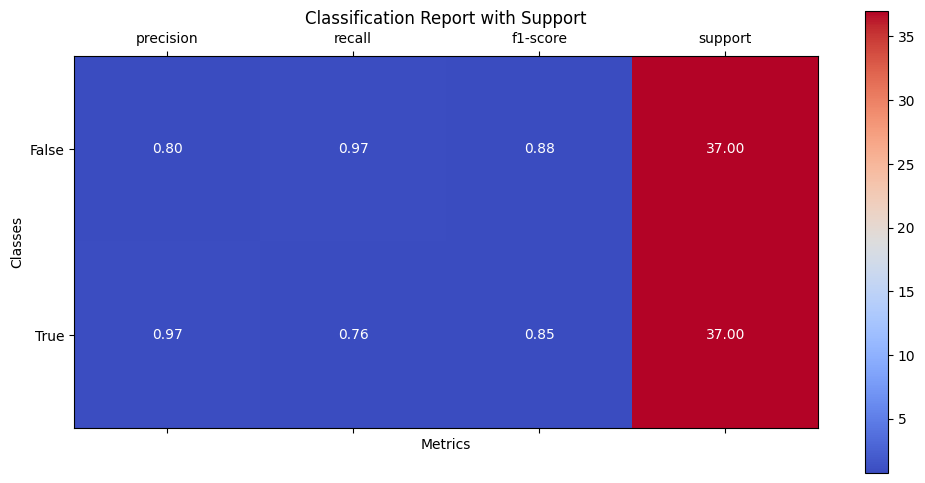

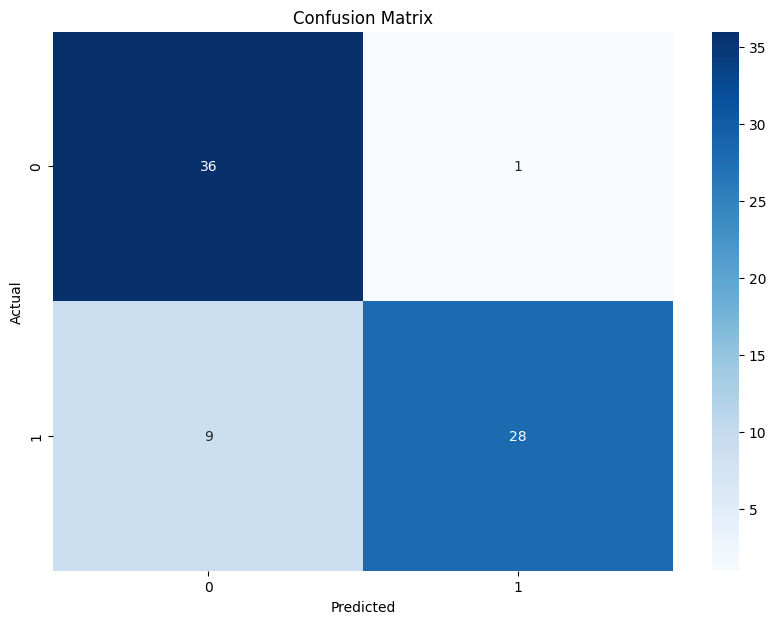

In [16]:
# Obtem melhor função de ativação
best_activation = max(results, key=lambda x: results[x]['mean']) # type: ignore

print(f'Melhor função de ativação: {best_activation}')

np.random.seed(seed)
model_best_activation = MLPClassifier(
    hidden_layer_sizes=(6,), max_iter=2000, learning_rate_init=0.32, momentum=0.72, activation=best_activation
)

model_best_activation.fit(X_train, y_train)

y_pred = model_best_activation.predict(X_test)

score = model_best_activation.score(X_test, y_test)
print(f'Score: {score}')

plot_classification_report_with_support(
    classification_report(y_test, y_pred, output_dict=True)
)

plot_confusion_matrix(confusion_matrix(y_test, y_pred))

## Quarta moficação: Número de Neurônios

No artigo foram usados 6 neurônios na camada oculta, aqui testamos com 2, 4, 6, 8, 10, 12, 14, 16, 18, 20.

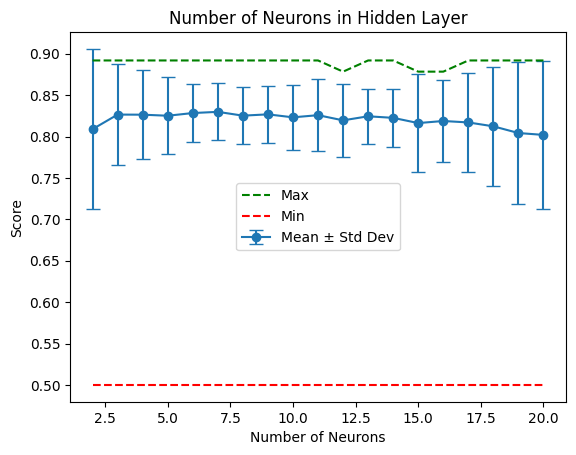

In [17]:
def num_neurons_experiment(number_of_neurons: Union[str, int]) -> np.float64:
    assert isinstance(number_of_neurons, int)
    model_60_40 = MLPClassifier(hidden_layer_sizes=(
        number_of_neurons,), max_iter=2000, learning_rate_init=0.32, momentum=0.72, activation='logistic')

    model_60_40.fit(X_train, y_train)
    return np.float64(model_60_40.score(X_test, y_test))

results = experiment_runner(range(2, 21), num_neurons_experiment)

plot_experiment_results(
    results,
    'Number of Neurons',
    'Score',
    'Number of Neurons in Hidden Layer'
)

### Melhor número de neurônios na camada oculta

Melhor número de neurônios: 7
Acurácia: 0.7972972972972973


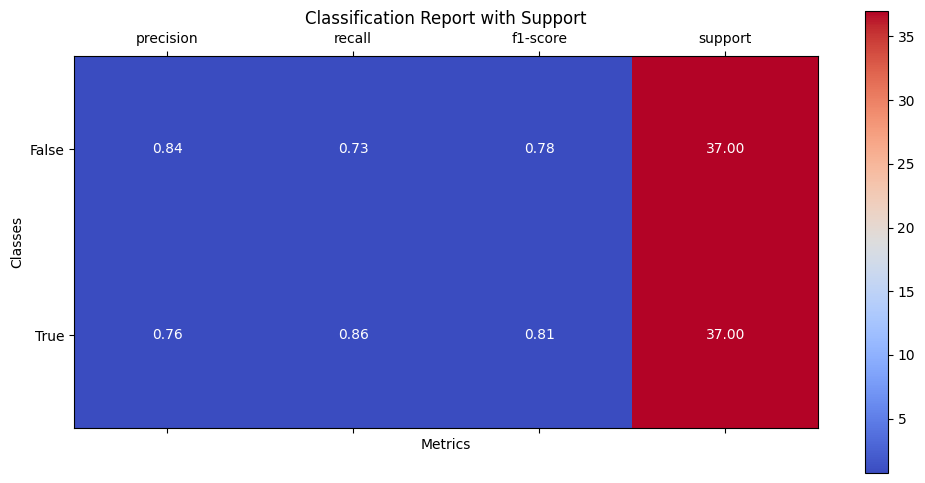

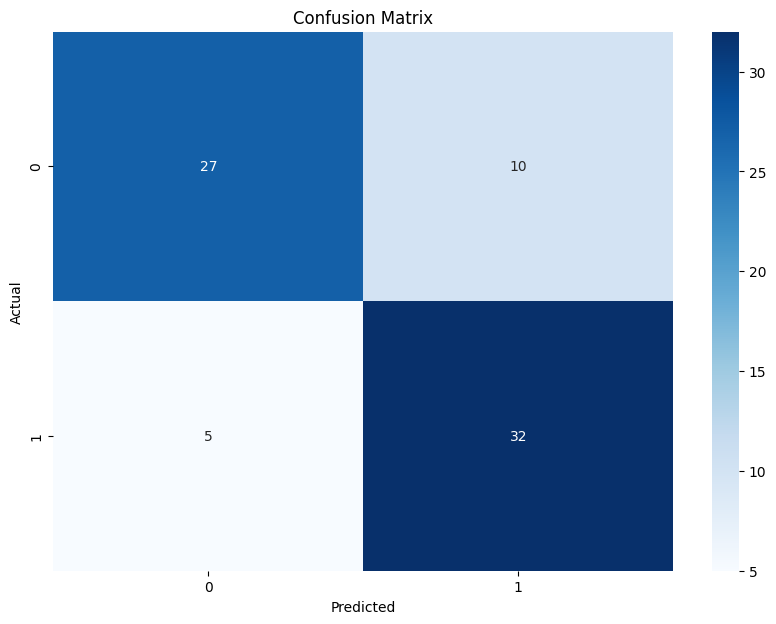

In [18]:
# Obtem melhor número de neurônios
best_neurons = max(results, key=lambda x: results[x]['mean']) # type: ignore

print(f'Melhor número de neurônios: {best_neurons}')

np.random.seed(seed)
model_best_neurons = MLPClassifier(
    hidden_layer_sizes=(best_neurons,), max_iter=2000, learning_rate_init=0.32, momentum=0.72, activation='logistic'
)

model_best_neurons.fit(X_train, y_train)

y_pred = model_best_neurons.predict(X_test)

score = model_best_neurons.score(X_test, y_test)

print(f'Acurácia: {score}')

plot_classification_report_with_support(
    classification_report(y_test, y_pred, output_dict=True)
)

plot_confusion_matrix(confusion_matrix(y_test, y_pred))

## Juntando todos os melhores parâmetros

Melhor número de folds: 4
Melhor número de epochs: 2200
Melhor função de ativação: identity
Melhor número de neurônios: 7
Score médio: 0.7844594594594595


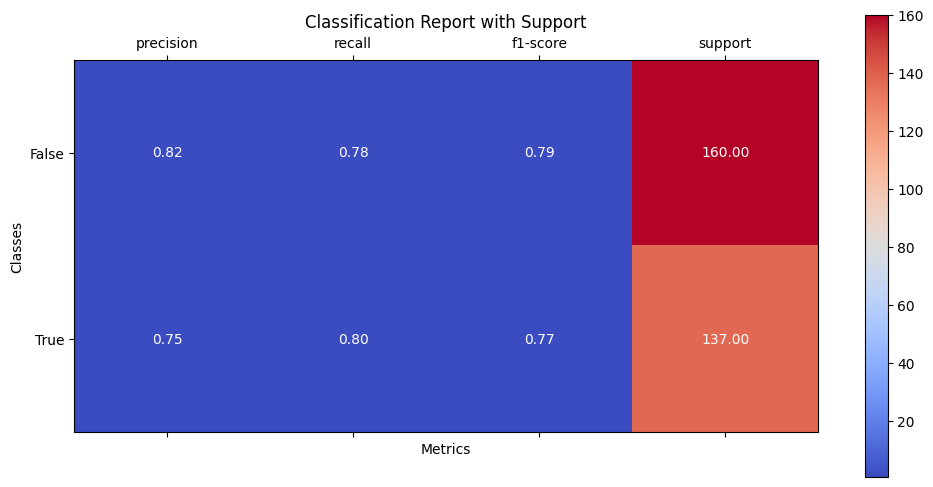

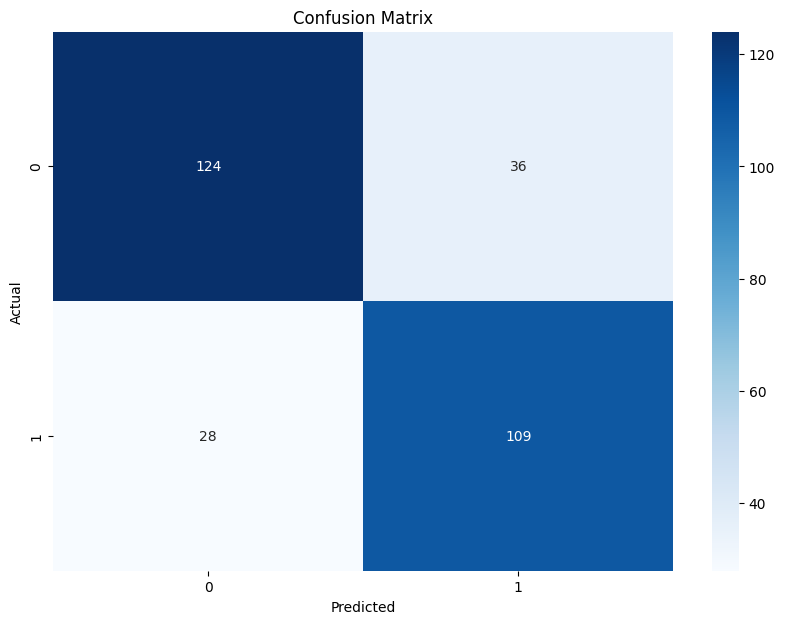

In [19]:
# Printa melhores parâmetros
print(f'Melhor número de folds: {best_n_folds}')
print(f'Melhor número de epochs: {best_epochs}')
print(f'Melhor função de ativação: {best_activation}')
print(f'Melhor número de neurônios: {best_neurons}')

# Cria um modelo com os melhores parâmetros
np.random.seed(seed)
model_best_params = MLPClassifier(
    hidden_layer_sizes=(best_neurons,), max_iter=best_epochs, learning_rate_init=0.32, momentum=0.72, activation=best_activation
)

# Treina utilizando K-Fold
kf = KFold(n_splits=best_n_folds, shuffle=True)

all_y_true = []
all_y_pred = []

scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_best_params.fit(X_train, y_train)
    
    y_pred = model_best_params.predict(X_test)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    
    score = model_best_params.score(X_test, y_test)
    scores.append(score)

print(f'Score médio: {np.mean(scores)}')

# Obtem relatório de classificação
plot_classification_report_with_support(
    classification_report(all_y_true, all_y_pred, output_dict=True)
)

# Obtem matriz de confusão
cm = confusion_matrix(all_y_true, all_y_pred)
plot_confusion_matrix(cm)

# Conclusão

Ao implementar o modelo do artigo e utilizar seeds aleatórias, encontramos uma que resulta em 86% de acurácia. O processo de encontrar uma seed foi feito, pois o artigo não fornece um conjunto de seeds para que os resultados obtidos nele sejam reproduziveis com alto grau de confiança. Ao testar de forma mais robusta, definindo as sementes de geração de números aleatórios e executando o treinamento dos modelos diversas vezes a fim de obter acurácia média, foi possível observar que para algumas variações de parâmetros, os resultados obtidos foram ligeralmente melhores nos melhores e piores casos na média.